In [1]:
import os
import yaml
import numpy as np
import pandas as pd
import datetime as dt
from copy import deepcopy
from yaml import Dumper, Loader
from random import randint
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['hatch.linewidth'] = 0.2  # previous pdf hatch linewidth

from ORBIT.core.library import initialize_library
from CORAL import SharedLibrary, GlobalManager, Pipeline

initialize_library(os.path.join(os.getcwd(), "library"))
projects = os.path.join(os.getcwd(), "updated_pipeline.csv")
base = os.path.join(os.getcwd(), "base.yaml")
pipeline = Pipeline(projects, base)
    
weather = pd.read_csv("library/weather/vineyard_wind_weather_1983_2017_orbit.csv", parse_dates=['datetime']).set_index('datetime')

ORBIT library intialized at '/Users/jnunemak/repos/external/CORAL/east_coast_analysis/library'


In [2]:
def get_installed_capacity_by(df, year):
    
    installed_capacity = df.loc[df["Date Finished"] < dt.datetime(year, 1, 1, 0, 0)]['capacity'].sum()
    
    partial = df.loc[(df["Date Finished"] > dt.datetime(year, 1, 1, 0, 0)) & (df["Date Started"] < dt.datetime(year, 1, 1, 0, 0))]
    for _, project in partial.iterrows():
        perc = (dt.datetime(year, 1, 1, 0, 0) - project["Date Started"]) / (project["Date Finished"] - project["Date Started"])
        installed_capacity += perc * project['capacity']
        
    return installed_capacity

In [3]:
library_path = os.path.join(os.getcwd(), "library")

allocations = {
    "wtiv": ('example_wtiv', 99),
    "feeder": ('example_feeder', 99),
    "port": [('northeast', 99), ('central', 99), ('south', 99)],
}

In [4]:
manager = GlobalManager(pipeline.configs, allocations, library_path=library_path)#, weather=weather)
manager.run()

In [5]:
df = pd.DataFrame(manager.logs).iloc[::-1]
df = df.reset_index(drop=True).reset_index()


port_map = pipeline.projects[["name", "port_region"]].set_index("name").to_dict()['port_region']
df['port'] = [port_map[name] for name in df['name']]

capacity_map = pipeline.projects[["name", "capacity"]].set_index("name").to_dict()['capacity']
df['capacity'] = [capacity_map[name] for name in df['name']]

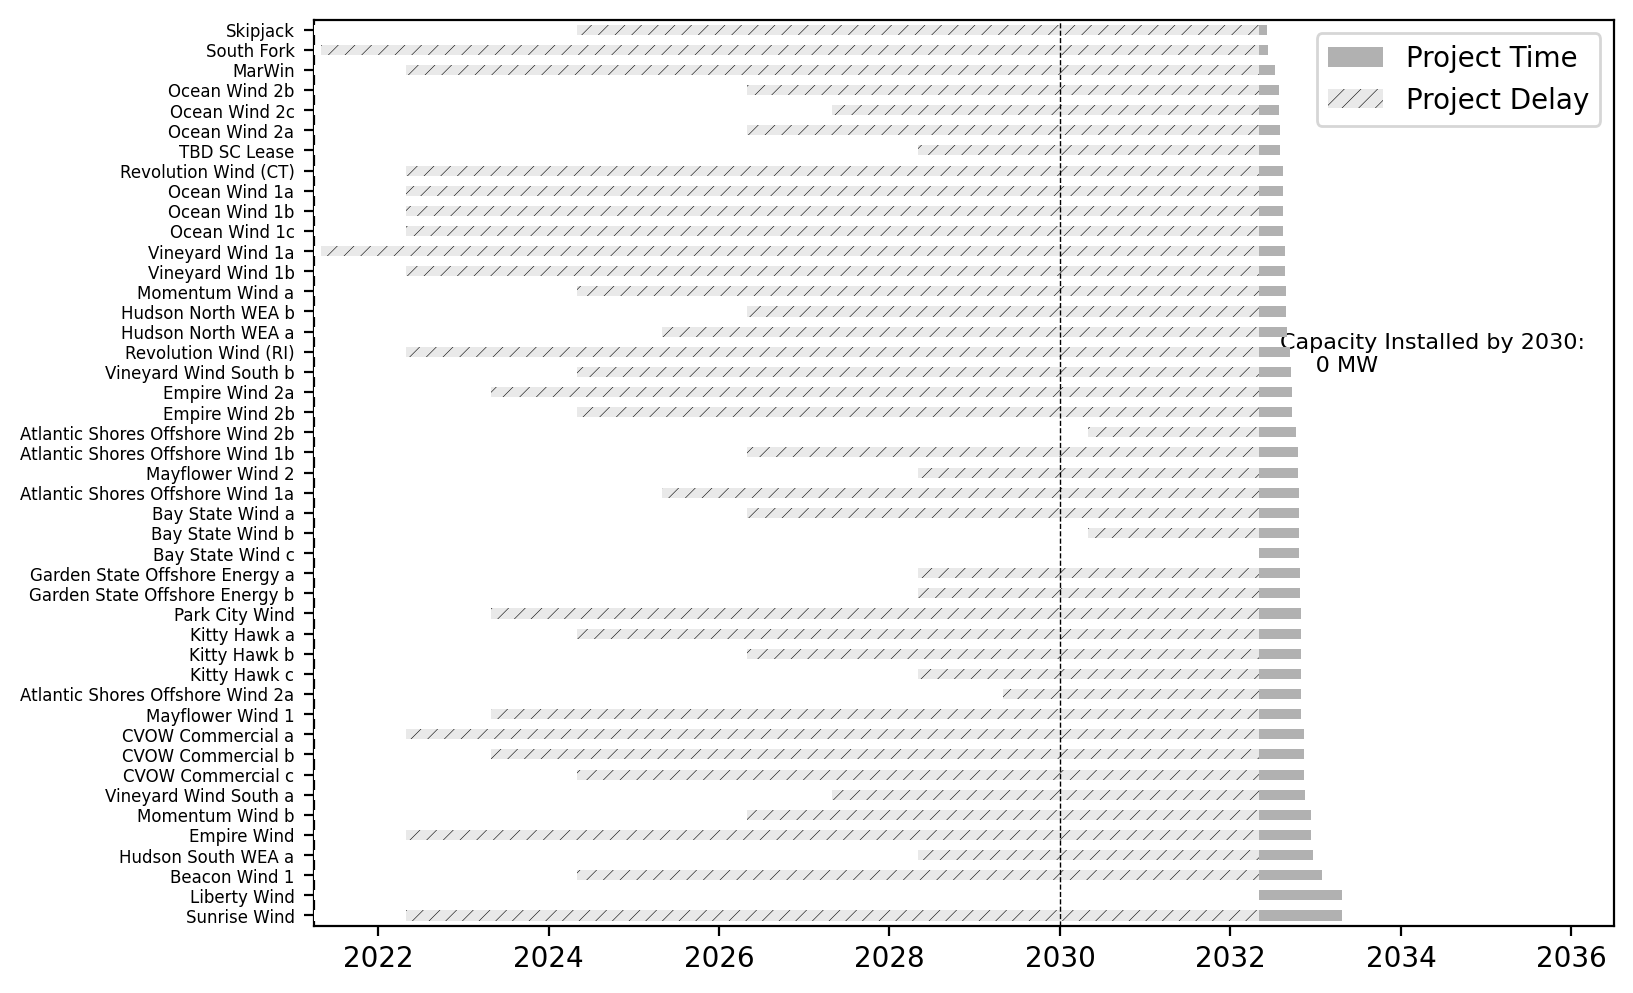

In [8]:
fig = plt.figure(figsize=(10, 6), dpi=200)
ax = fig.add_subplot(111)

color_map = {
    "northeast": "tab:green",
    "central": "tab:red",
    "south": "tab:blue"
}

df["Date Finished"].plot(kind="barh", ax=ax, zorder=4, label="Project Time", color="#b1b1b1")
df["Date Started"].plot(kind="barh", color="#e9e9e9", ax=ax, zorder=4, label="Project Delay", hatch="////", linewidth=0.5)
df["Date Initialized"].plot(kind='barh', ax=ax, zorder=4, label="__nolabel__", color='w')

# df.plot(kind="scatter", x="request-wtiv-date", y="index", color='tab:orange', ax=ax, zorder=5, label="WTIV", marker="x")

# groups = df.groupby("port")
# for name, group in groups:
#     group.plot(kind="scatter", x="request-port-date", y="index", ax=ax, marker="x", c=color_map[name], zorder=5, label=f"{name} ports".capitalize())

ax.axvline(dt.date(2030, 1, 1), lw=0.5, ls="--", color="k", zorder=6)
    
# Plot formatting
ax.set_xlabel("")
ax.set_ylabel("")
_ = ax.set_yticklabels(df['name'])
plt.yticks(fontsize=6)
ax.legend()
ax.set_xlim(manager._start - dt.timedelta(days=30), dt.date(2036, 6, 1) + dt.timedelta(days=30))#df["Date Finished"].max() + dt.timedelta(days=30))

installed_capacity = get_installed_capacity_by(df, 2030)
ax.text(x=dt.date(2032, 8, 1), y=27, s=f"Capacity Installed by 2030:\n     {installed_capacity:,.0f} MW", fontsize=8)

fig.subplots_adjust(left=0.25)

In [38]:
fig.savefig("figures/bau.png")

In [44]:
year= 2030
partial = df.loc[(df["Date Finished"] > dt.datetime(year, 1, 1, 0, 0)) & (df["Date Started"] < dt.datetime(year, 1, 1, 0, 0))]

In [54]:
for _, project in partial.iterrows():
    print(project['name'])
    perc = (dt.datetime(year, 1, 1, 0, 0) - project["Date Started"]) / (project["Date Finished"] - project["Date Started"])
    
    print(perc)

Vineyard Wind South a
0.2415246472420744
Mayflower Wind 2
0.2512056115738711


In [53]:
perc

0.2512056115738711

In [12]:
import os
from ORBIT import ProjectManager
from ORBIT.core.library import initialize_library

initialize_library

project = ProjectManager(pipeline.configs[0])
project.run()

LibraryItemNotFoundError: _shared_pool_:northeast.yaml not found in /Users/jnunemak/repos/external/CORAL/east_coast_analysis/library/project/port.

In [7]:
config = {
    'wtiv': '_shared_pool_',
    'feeder': '_shared_pool_',
    'num_feeders': 2,
    'site': {'depth': 20, 'distance': 40},
    "plant": {},
    'port': "_shared_pool_",
    'turbine': "12MW_generic",
    
    "design_phases": [],
    "install_phases": ["TurbineInstallation"]
}

with open("turbine_install.yaml", "w") as f:
    yaml.dump(config, f, Dumper=Dumper)